In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import sys
import IPython
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import time
from time import sleep,gmtime,strftime
import os
import warnings
warnings.filterwarnings("ignore")

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Systems\AppData\Local\sagemaker\sagemaker\config.yaml


In [2]:
data=pd.read_csv("rawdata/spam.csv",encoding="ISO-8859-1")
data.shape

(5572, 5)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
#lets rename the column names and give them more understanding name
data.rename(columns={"v1":'label',"v2":"text"},inplace=True)
data.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
#lets check the missing value counts
data.isna().sum()

label            0
text             0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [6]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [7]:
#feature encoding - converting target categorical column into numerical

data['label']=data['label'].map({"ham":0,"spam":1})
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
#lets check & remove the duplicates
data.duplicated().sum()
data.drop_duplicates(keep='first')

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


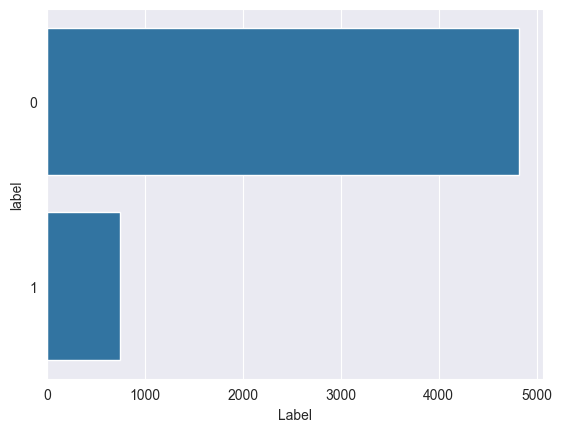

In [9]:
#lets check the counts of label variable 
#plt.figure(figsize=(12,6))
data_eda=data.copy()
sns.countplot(data=data_eda,y='label')
plt.xlabel("Label")

plt.show()
import warnings
warnings.filterwarnings("ignore")

In [10]:
#!pip install nltk   #--install the packages for first time
import nltk
nltk.download('punkt')

#import nltk: This line imports the NLTK library into your Python environment. 
# NLTK provides various tools and resources for working with human language data.

# nltk.download('punkt'): 
# The 'punkt' tokenizer is used for tokenization, which means breaking text into individual words or sentences (tokenizing them) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Systems\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
data_eda['num_characters']=data_eda['text'].apply(len) #getting the length of each sentence usinh chracters len
data_eda['num_words']=data_eda['text'].apply(lambda x : len(nltk.word_tokenize(x))) #getting the words count in each sentence
data_eda['num_sentences']=data_eda['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
data_eda.describe()

,label,num_characters,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.134063,80.118808,18.699390,1.996411
std,0.340751,59.690841,13.741932,1.520159
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,61.000000,15.000000,1.500000
75%,0.000000,121.000000,27.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [12]:
#spam and ham messages count as per num_chracters,words, sentences
data_eda.groupby('label')[['num_characters','num_words','num_sentences']].describe().T


label                           0           1
num_characters count  4825.000000  747.000000
               mean     71.023627  138.866131
               std      58.016023   29.183082
               min       2.000000   13.000000
               25%      33.000000  132.500000
               50%      52.000000  149.000000
               75%      92.000000  157.000000
               max     910.000000  224.000000
num_words      count  4825.000000  747.000000
               mean     17.276269   27.891566
               std      13.988585    6.867007
               min       1.000000    2.000000
               25%       8.000000   25.000000
               50%      13.000000   29.000000
               75%      22.000000   32.000000
               max     220.000000   46.000000
num_sentences  count  4825.000000  747.000000
               mean      1.837720    3.021419
               std       1.454388    1.537580
               min       1.000000    1.000000
               25%       1.000000    2.000000
               50%       1.000000    3.000000
               75%       2.000000    4.000000
               max      38.000000    9.000000

<Axes: xlabel='num_sentences', ylabel='Count'>

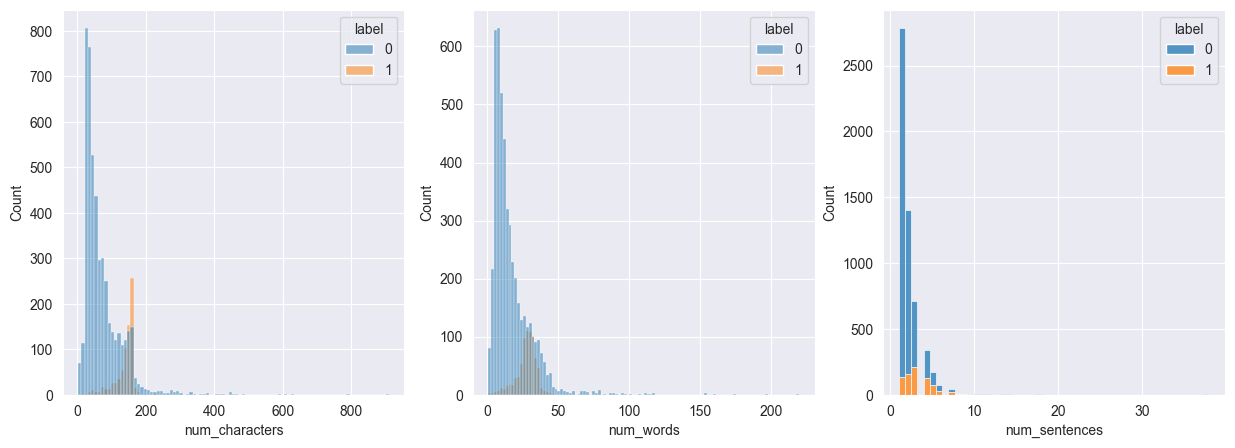

In [13]:
#visualize the histplot 
fix,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
sns.histplot(data=data_eda,x='num_characters',hue='label',ax=ax[0])
sns.histplot(data=data_eda,x='num_words',hue='label',ax=ax[1])
sns.histplot(data=data_eda,x='num_sentences',hue='label',ax=ax[2],bins=50,multiple='stack')

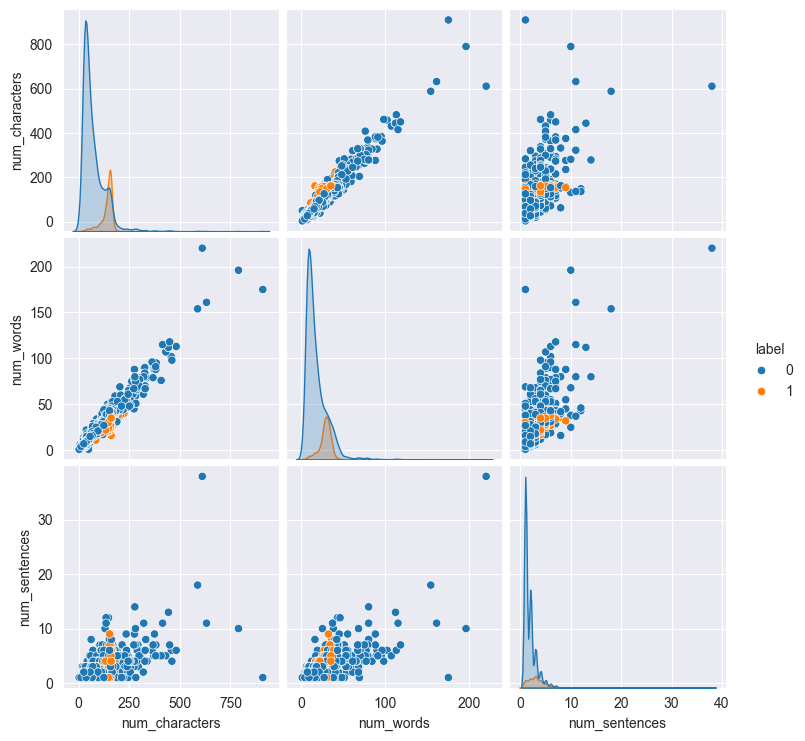

In [14]:
sns.pairplot(data_eda,hue='label')


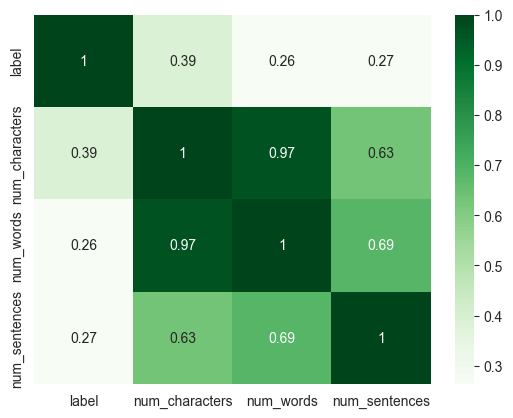

In [15]:
# Select only numerical columns
numerical_data = data_eda.select_dtypes(include=np.number)

# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='Greens')
plt.show()

In [16]:
nltk.download('stopwords')
#The line nltk.download('stopwords') in NLTK downloads a collection of stopwords for various languages.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Systems\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()    

def transform_text(text):
    text=text.lower()
    y=[]
    #tokenization
    text=nltk.word_tokenize(text)
    for i in text:
        if i.isalnum():
            y.append(i)
    text=y[:]
    y.clear()
    #removing stopwords and punctuations
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text=y[:]
    y.clear()
    
    #stemming applied on text
    for i in text:
        y.append(ps.stem(i))
    return y

data_eda['transformed_text']=data_eda['text'].apply(transform_text)


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


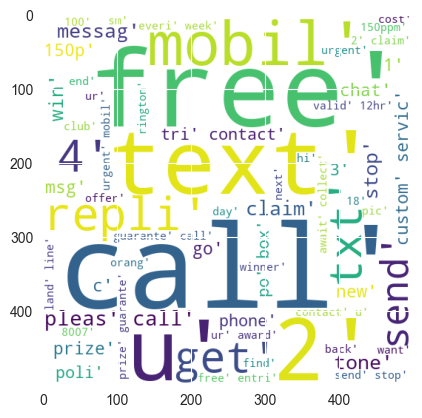

In [18]:
!pip install wordcloud 
#lets check the most occuring words using wordcloud library
from wordcloud import WordCloud
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc=wc.generate(data_eda[data_eda['label']==1]['transformed_text'].astype('str').str.cat(sep=" "))
plt.imshow(spam_wc)

In [19]:
#counting the no of words repeating
spam_corpus=[]
for msg in data_eda[data_eda['label']==1]['transformed_text'].tolist():
    for word in msg:
        spam_corpus.append(word)
len(spam_corpus)
        

11490

Text(0.5, 1.0, 'top 30 repeating words in spam text')

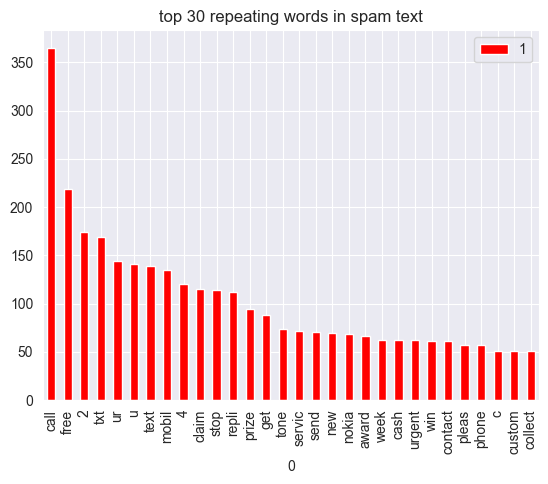

In [20]:
from collections import Counter
pd.DataFrame(Counter(spam_corpus).most_common(30)).plot(kind='bar',x=0,color='red')
plt.title("top 30 repeating words in spam text")

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the text vectorizer
tf = TfidfVectorizer()

k=tf.fit_transform(data_eda['transformed_text'].astype('str')).toarray()
k.shape

(5572, 6708)

In [22]:
k=pd.DataFrame(k,columns=tf.get_feature_names_out())
k

,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,02073162414,02085076972,...,zouk,zyada,åè10,åð,åòharri,åòit,åômorrow,åôrent,ìä,ìï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#vector embedding -convert text to numerical as per their occurence frequency
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv=CountVectorizer()
tf=TfidfVectorizer()
X=tf.fit_transform(data_eda['transformed_text'].astype('str')).toarray()
X=pd.DataFrame(X,columns=tf.get_feature_names_out())
X.shape

(5572, 6708)

In [24]:
from sklearn.model_selection import train_test_split
y=data_eda['label']
y


0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int64

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3,random_state=33)


In [26]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.svm import SVC
import time
import datetime
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,classification_report,f1_score
from sklearn.metrics import make_scorer
f1_scorer=make_scorer(f1_score)

In [27]:
# creating two dataframe for storing hyperparameters and model's output
df_models_output=pd.DataFrame(columns=['model','accuracy','precision','recall','roc','f1_score'])
df_models_output
df_hyperparameter=pd.DataFrame(columns=['modelname','hyperparameter'])

In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt  # Import for plotting


def compute_evaluation_metric(algo, X_test, y_actual, y_pred, y_pred_prob):
    cm = confusion_matrix(y_actual, y_pred, labels=y.value_counts().index)
    print(f"confusion matrix -\n {cm}\n")

    accuracy = accuracy_score(y_actual, y_pred)
    print(f"accuracy score : {accuracy}")

    TP = np.diag(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    TPR = np.round(np.mean(TP / (TP + FN)), 4)
    TNR = np.round(np.mean(TN / (TN + FP)), 4)
    FPR = np.round(np.mean(FP / (FP + TN)), 4)
    precision = TP / (TP + FP)
    f1score = f1_score(y_test, y_pred)

    print(f"Precision for positive class is {precision}")
    print(f"TPR/Recall is {TPR}")
    print(f"TNR/Specifity is {TNR}")
    print(f"FPR is {FPR}")
    print(f"F1 score is - {f1score}")
    print(f"\n classification report - :\n {classification_report(y_actual, y_pred)}")

    ROC = roc_auc_score(y_actual, y_pred)
    print(f"ROC -{ROC} ")  # ROC curve method for binary classification problems

    roc_disp = RocCurveDisplay.from_predictions(y_actual, y_pred)
    roc_disp.plot()  # Plot the ROC curve with default settings
    plt.show()

    return algo, accuracy, precision, TPR, ROC, f1score

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)

MODEL 4: RANDOM FOREST

In [36]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
params = {'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}
cv_method = StratifiedKFold(n_splits=5)  # Set the cross-validation method

gs_rf = GridSearchCV(estimator=rf, cv=cv_method, param_grid=params, verbose=1, n_jobs=-1, scoring='accuracy')
gs_rf.fit(X_train, y_train)
print(gs_rf.best_estimator_)



Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestClassifier()


In [37]:
import pandas as pd

df_hyperparameter = pd.DataFrame(columns=['modelname', 'hyperparameter'])
new_row = {'modelname': 'RF', 'hyperparameter': 'criterion: gini, max_features: sqrt'}
df_hyperparameter.loc[len(df_hyperparameter)] = new_row
print(df_hyperparameter)


  modelname                       hyperparameter
0        RF  criterion: gini, max_features: sqrt


MODEL 1: NAIVE BAYES MODEL

In [38]:
# # %%time
# #lets use hyperparamater tuning for NB model
# 
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


mnb=MultinomialNB()
parmas={"alpha":[.001,.01,.1,1,2]}
cv_method=RepeatedStratifiedKFold(n_splits=10,n_repeats=10,random_state=33)
gs_nb=GridSearchCV(estimator=mnb,
                  cv=cv_method,
                  param_grid=parmas,
                  verbose=1,
                  scoring=f1_scorer)
gs_nb.fit(X_train,y_train)
print(gs_nb.best_estimator_)

Fitting 100 folds for each of 5 candidates, totalling 500 fits
MultinomialNB(alpha=1)


In [39]:
new_row = {'modelname': 'MultiNB', 'hyperparameter': 'MultinomialNB(alpha=0.1,1)'}  # Fix parenthesis

# Concatenate the DataFrame with a single-row DataFrame containing the new row
df_hyperparameter = pd.concat([df_hyperparameter, pd.DataFrame([new_row])], ignore_index=True)

print(df_hyperparameter)


  modelname                       hyperparameter
0        RF  criterion: gini, max_features: sqrt
1   MultiNB           MultinomialNB(alpha=0.1,1)


In [40]:
import pickle  #used to create pickle files
import joblib  #used to save models

print("creating pickle file")
# pickle.dump(sclf,open('spam_detector.pkl','wb'))
pickle.dump(tf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('mnb_spam_detector.pkl','wb'))

creating pickle file
